# ChromProcess Introduction Part 1

This series of notebooks runs through one possible way of using the code contained in ChromProcess, thereby introducing its core functionality. These notebooks should work fine in the folder they are found in if ChromProcess can be imported (see installation instructions). ChromProcessIntroduction_1 shows how chromatograms and their associated data can be loaded and how peak information can be extracted from them and stored.

# What is ChromProcess?

ChromProcess is a collection of Python functions and objects which provide a framework for manipulating sets of chromatographic data. The code is currently flexible enough to work with what we deal with in the [Huck Lab](https://www.hucklab.com).

There are several types of information required to reproducibly assign and/or quantify chromatographic peaks. ChromProcess is one way of interfacing these various information sources. By 'interfacing', I mean placing the data in in an appropriate format and organisational structure.

# Source Files

## Experiment-specific files

Experimental data and 'metadata' (primary data), go in the front of the analysis pipeline. Files containing information about the experiment should not be altered during analysis. Primary data files consist of several chromatographic data files (as of writing ChromProcess can load `.cdf`, `.txt` or `.csv` format) and a conditions file (comma-separated values `.csv`). The chromatographic data files should be named in such a way that they can be sorted programatically. For example, the sequence `chrom_001.csv`, `chrom_002.csv`, `chrom_003.csv` would be appropriate. The structure and contents of an example conditions file are shown below.

In [1]:
import csv

with open('Sample_analysis/Example/ExperimentalData/example_conditions.csv', "r") as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        line = row[0] + ': '
        line += ','.join([x for x in row[1:] if x != ''])
        print(line)

Dataset: example_dataset_name
start_experiment_information: 
Series_values: 10,20,30
Series_unit: time/ s
end_experiment_information: 
start_conditions: 
dihydroxyacetone/ M: 2
formaldehyde/ M: 2
NaOH/ M: 0.12
CaCl2/ M: 0.06
water/ M: 0
end_conditions: 


- Dataset: Reference code for the experiment
- start_experiment_information: # tag for experiment information field
- series_values: ordered values associated with the chromatograms (e.g. timepoints)
- series_unit: the units for series_values; format: {name}/ {unit}
- end_experiment_information: # tag for experiment information field
- start_conditions: # tag for experiment conditions field
    - Information between these two tags forms key: list pairs, e.g.
        - formaldehyde_concentration/ M, 0.2
        - water_flow_rate/ L/h, 0.1, 0.005, 0.0001 
- end_conditions: # tag for experiment conditions field

Keeping track of the operations performed on the primary data is an important component of a reproducible pipeline. To record and input details of analysis operations, an analysis details file (`.csv`) is also included alongside the primary data. The structure and contents of an example analysis file are shown below.

In [2]:
with open('Sample_analysis/Example/Analysis/example_analysis_details.csv', "r") as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        line = row[0] + ': '
        line += ','.join([x for x in row[1:] if x != ''])
        print(line)

Dataset: example_dataset_name
Method: GCMS
Instrument: GCv Agilent/JEOL
Instrument_method: Method 5
Derivatisation_method: 75 uL EtONH2.HCl; 30 mins @ 70 oC; 25 uL N;O-Bis(trimethylsilyl)trifluoroacetamide; 30 mins @ 70 oC; dilution to 200 uL with internal standard solution
Calibration_model: quadratic
Calibration_file: 2020_03_16_GCMS_Calibrations.csv
Regions: 7.4,8.4,10.2,11.2,12.8,14.0
Internal_standard_region: 6.6,6.79
Extract_mass_spectra: FALSE
Mass_spectra_filter: 500
Peak_pick_threshold: 0.1
Dilution_factor: 5.714285714
Dilution_factor_error: 0.0447
Internal_standard_concentration: 0.0008
Internal_standard_concentration_error: 9.89E-06


The fields are as follows:

- Dataset: Experiment code
- Method: Analysis method used to collect the data (e.g. GCMS or HPLC).
- regions: pairs of lower, upper retention times which outline regions of the chromatogram in which the program will search for peaks.
- internal_standard_region: a pair of lower, upper bounds between which the internal standard (internal standard) should lie.
- extract_mass_spectra: whether to extract mass spectra information from the files during the analysis (TRUE) or not (FALSE).
- peak_pick_threshold: Threshold (as a fraction of the highest signal in a region) above which peaks will be detected.
- dilution_factor: Dilution factor applied during sample preparation (multiplying the concentrations derived from peak integrals by this value will convert them into those present in the unprepared sample)
- dilution_factor_error: standard error for the dilution factor.
- internal_standard_concentration: Concentration of the internal standard (internal standard)
- internal_standard_concentration_error: Standard error of the concentration of the internal standard (internal standard).

Additionally, a local assignments file (initially an empty `.csv` file) can be added to the project. These files can be arranged in folders however you wish. Whichever organisation scheme used must be systematic. An example struture is shown below:

## Files applicable to several experiments

Calibration information for an instrument may be applicable to one or more sets of data. This information can therefore be stored separately from the primary data. Alternatively, a copy of a calibration file can be included within the directory of each experiment. This method has the benefit of providing a more unambiguous association of the data to the calibration. On the other hand, if changes must be made to a calibration file (e.g. adding a new calibration for a compound), multiple files must be updated which may be more labour-intensive and error-prone. Either way, creating a file which assigns each experiment to a calibration file (including paths to each file) is beneficial, as is creating a workflow for updating analyses in response to changes to the source files.

# Overview of an Example Analysis Pipeline

The first step is to create peak table files containing peak positions, boundaries and integrals for each chromatogram. Each chromatogram is loaded in as a `Chromatogram` object. The analysis and conditions files are also loaded as `Analysis_Information` and `Experiment_Conditions` objects, respectively. Information in the analysis file is used to find peaks in each chromatogram before each peak is integrated. The `Chromatogram` can then be used to create a peak table with associated condition information, if required.

Before beginning the analysis, the chromatograms should be inspected and information should be input into the analysis file as appropriate (regions, concentrations, etc.). First, the source files are directly converted into objects:

In [3]:
import os
from ChromProcess.Loading import chrom_from_csv

chromatogram_directory = 'Sample_analysis/Example/ExperimentalData/ExampleChromatograms'
chromatogram_files = os.listdir(chromatogram_directory)
chromatogram_files.sort()
chroms = []
for f in chromatogram_files:
    chroms.append(chrom_from_csv(f'{chromatogram_directory}/{f}'))

Before proceeding with the analysis, the chromatograms are inspected for quality (up to you as a scientist!) and for regions to be selected for peak picking. The plots can be generated by any plotting method that you are comfortable with. Below is an example using `matplotlib`.

When picking regions for peak picking, the idea is to select regions in the chromatogram in which the peaks have similar intensities. An arbitrary number of boundaries can be input. At one extreme, a single boundary for the beginning and end of the chromatogram can be use. At the other logical extreme, boundaries for individual peaks can be input. Bear in mind that the current implementation of peak picking does not account for retention time drift between chromatograms, and the regions passed to each chromatogram are the same. Therefore, 'manual' peak picking in the manner may not be accurate.

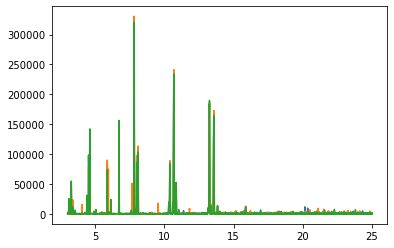

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for c in chroms:
    ax.plot(c.time, c.signal, label = c.filename)
plt.show()

In [5]:
from ChromProcess.Loading import analysis_from_csv
from ChromProcess.Loading import conditions_from_csv
conditions_file = 'Sample_analysis/Example/ExperimentalData/example_conditions.csv'
analysis_file = 'Sample_analysis/Example/Analysis/example_analysis_details.csv'
conditions = conditions_from_csv(conditions_file)
analysis = analysis_from_csv(analysis_file)

Next, a peak for the internal standard is picked using information in `analysis` (the function modifies the chromatogram object passed to it by inserting the internal standard information, currently, only one internal standard is supported). This step assumes that the internal standard selected in the chromatograms is a single peak, with no peaks originating from the sample overlapping it (within the `analysis.internal_standard_region`).

In [6]:
from ChromProcess.Processing import internal_standard_integral

is_start = analysis.internal_standard_region[0]
is_end = analysis.internal_standard_region[1]
for c in chroms:
    internal_standard_integral(c, is_start, is_end)

Information from `analysis` (originating in the analysis information file described above) is again used to pick peaks in defined regions of each chromatogram. The functions add peak information into chromatograms.

In [7]:
from ChromProcess.Processing import find_peaks_in_region
from ChromProcess.Processing import add_peaks_to_chromatogram
from ChromProcess.Processing import integrate_chromatogram_peaks

threshold = analysis.peak_pick_threshold
for chrom in chroms:
    for reg in analysis.regions:
            peaks = find_peaks_in_region(
                                            chrom, 
                                            reg[0], 
                                            reg[1], 
                                            threshold = threshold 
                                        )
            add_peaks_to_chromatogram(peaks, chrom)
            integrate_chromatogram_peaks(chrom)

Inspecting peak picking:

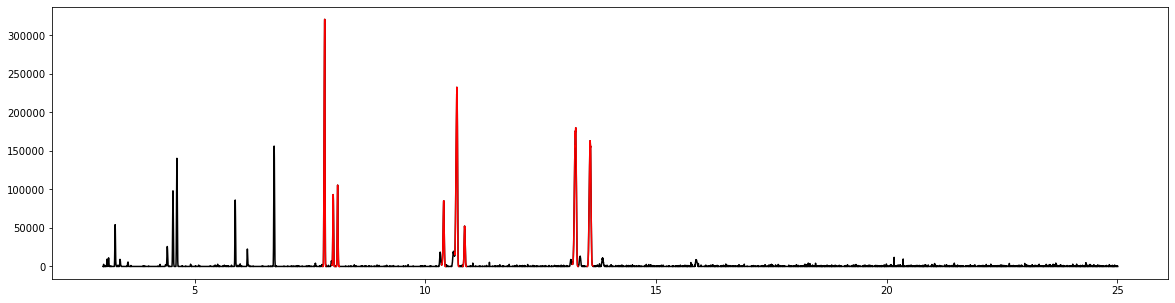

In [8]:
test_chromatogram = chroms[0]

time = test_chromatogram.time
signal = test_chromatogram.signal

fig, ax = plt.subplots(figsize = (20,5))
ax.plot(time, signal, c = 'k', zorder = 0)
for c,pk in enumerate(test_chromatogram.peaks):
    idx = test_chromatogram.peaks[pk].indices
    ax.plot(time[idx], signal[idx], c= 'r', zorder  = 1)
  
plt.show()

Peaks collections can then be written directly from each `Chromatogram` whilst inserting information from conditions files if required. Note here that the ordering of chromatograms must be the same as the order or series values in the conditions file.

In [9]:
import os
# Output peak collection
peak_collection_directory = 'Sample_analysis/Example/ExperimentalData/ExamplePeakCollections'

os.makedirs(peak_collection_directory, exist_ok = True)
for c,v in zip(chroms, conditions.series_values):
    c.write_peak_collection(filename = f'{peak_collection_directory}/{c.filename}',
                        header_text = f"{conditions.series_unit},{v}\n",
                        )

It make also be convenient to store the chromatographic signals in a simple `.csv` format for use with other software. These files can be created using one of Chromatogram's methods:

In [10]:
chromatogram_output_folder = 'Sample_analysis/Example/ExperimentalData/ChromatogramCSV'
for c in chroms:
    c.write_to_csv(filename = f'{chromatogram_output_folder}/{c.filename}')

Peaks can also be loaded from peak_collection csv files.

In [11]:
from ChromProcess.Loading.peak.peak_from_csv import peak_from_csv

for c, chrom in enumerate(chroms, 1):
    peak_file = f"{peak_collection_directory}/chrom_00{c}.csv"
    peak_features = peak_from_csv(peak_file, chrom)
    add_peaks_to_chromatogram(peak_features, chrom)

That concludes this tutorial notebook. The next tutorial notebook will deal with processing the peak tables into series data.